# Bank Customer Churn — Exploratory Data Analysis (EDA)

## Project Context
Customer churn is a critical challenge for the banking industry: retaining existing customers is significantly more cost-effective than acquiring new ones.

This notebook is the **first stage** of an end-to-end ML pipeline. The goal is to explore the dataset, validate data quality, and identify potential drivers of churn before modeling.

## Contents
- Data source & acquisition
- Dataset schema / feature types
- Target distribution (class imbalance)
- Univariate distributions
- Churn vs key numerical features
- Categorical feature churn rates
- Summary & next steps


## Objectives of this notebook
- Understand the structure and origin of the dataset
- Load the data in a fully reproducible way
- Perform an initial inspection of features and target variable
- Identify potential data quality and preprocessing issues


In [1]:
from __future__ import annotations

# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System utilities
from pathlib import Path
import warnings

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.3f}".format)

# Visualization style
plt.style.use("seaborn-v0_8")
sns.set_context("notebook")

# Warnings / reproducibility
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

# Dataset config (portable)
TARGET_COL = "churn"
LOCAL_DATA_PATH: Path | None = None  # e.g., Path("../data/raw/bank_churn.csv")



## Data Source & Acquisition

This project uses the **Bank Customer Churn Dataset** from Kaggle:
- Source: [gauravtopre/bank-customer-churn-dataset](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset)

The dataset describes customers of a European retail bank and is commonly used for churn prediction tasks.

### Reproducibility notes
- In **Google Colab**, we can download the dataset programmatically.
- In a **local environment**, you can set `LOCAL_DATA_PATH` to a CSV on disk (recommended for stable runs without Kaggle auth).


In [2]:
# KaggleHub (Colab-friendly). For local runs, prefer LOCAL_DATA_PATH.
try:
    import kagglehub  # type: ignore
except Exception:
    %pip install -q kagglehub
    import kagglehub  # type: ignore


In [3]:
# Resolve data path (LOCAL first, then KaggleHub)
if LOCAL_DATA_PATH is not None:
    data_path = LOCAL_DATA_PATH
else:
    dataset_dir = Path(
        kagglehub.dataset_download("gauravtopre/bank-customer-churn-dataset")
    )
    csv_files = sorted(dataset_dir.glob("*.csv"))
    assert csv_files, f"No CSV files found in: {dataset_dir}"
    data_path = csv_files[0]

print("Using dataset file:", data_path)


Using Colab cache for faster access to the 'bank-customer-churn-dataset' dataset.
Using dataset file: /kaggle/input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv


In [4]:
# Load dataset
assert data_path.exists(), f"File not found: {data_path}"

df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,15647311,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,15619304,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,15701354,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,15737888,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


## Dataset Structure and Data Types

Before any transformations, we inspect the structure of the dataset:
- number of rows and columns
- data types
- presence of missing values

This step helps identify potential preprocessing requirements.


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


## Dataset Overview

Based on the dataset structure, we observe:
- 10,000 customer records
- 12 columns in total
- No missing values
- A mix of numerical and categorical features

Before proceeding further, we explicitly identify feature types
to structure the exploratory analysis.



In [6]:
ID_COL = "customer_id"

# Numerical features (excluding target + identifiers)
numerical_features = [
    col
    for col in df.select_dtypes(include=["int64", "float64"]).columns
    if col not in {TARGET_COL, ID_COL}
]

# Categorical features
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

numerical_features, categorical_features


(['credit_score',
  'age',
  'tenure',
  'balance',
  'products_number',
  'credit_card',
  'active_member',
  'estimated_salary'],
 ['country', 'gender'])

## Target Variable Distribution

We now analyze the distribution of the target variable.
This step is important to assess potential class imbalance
and to guide metric selection in later stages.


In [7]:
churn_counts = df[TARGET_COL].value_counts().sort_index()
churn_ratio = df[TARGET_COL].value_counts(normalize=True).sort_index()

summary = pd.DataFrame({"count": churn_counts, "ratio": churn_ratio}).assign(
    percent=lambda x: (100 * x["ratio"]).round(2)
)
summary


,count,ratio,percent
churn,,,
0,7963,0.796,79.630
1,2037,0.204,20.370


## Target imbalance (quick take)

Churn datasets are typically imbalanced. We’ll account for this later via:
- ROC-AUC / PR-AUC tracking
- class-weighting / resampling (if needed)
- threshold tuning to optimize recall for churners


## Data quality quick checks

Before deep EDA, run a few sanity checks:
- missing values
- duplicate rows / duplicate IDs
- basic target validity

## Numerical feature distributions

We start by examining numerical distributions to understand ranges, skewness/outliers, and potential need for scaling/transformations.


In [8]:
# Data quality checks
quality = {
    "rows": len(df),
    "cols": df.shape[1],
    "missing_cells": int(df.isna().sum().sum()),
    "duplicate_rows": int(df.duplicated().sum()),
    "duplicate_customer_id": int(df[ID_COL].duplicated().sum()) if ID_COL in df.columns else None,
    "target_unique": sorted(df[TARGET_COL].dropna().unique().tolist()),
}
quality


{'rows': 10000,
 'cols': 12,
 'missing_cells': 0,
 'duplicate_rows': 0,
 'duplicate_customer_id': 0,
 'target_unique': [0, 1]}

## Target distribution (plot)

A quick visual check of class balance.

## Churn vs numerical features

Compare numerical features between churned and non-churned customers to spot strong associations early.


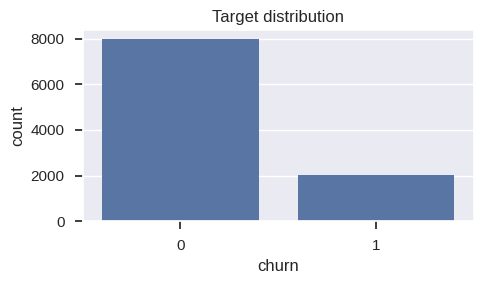

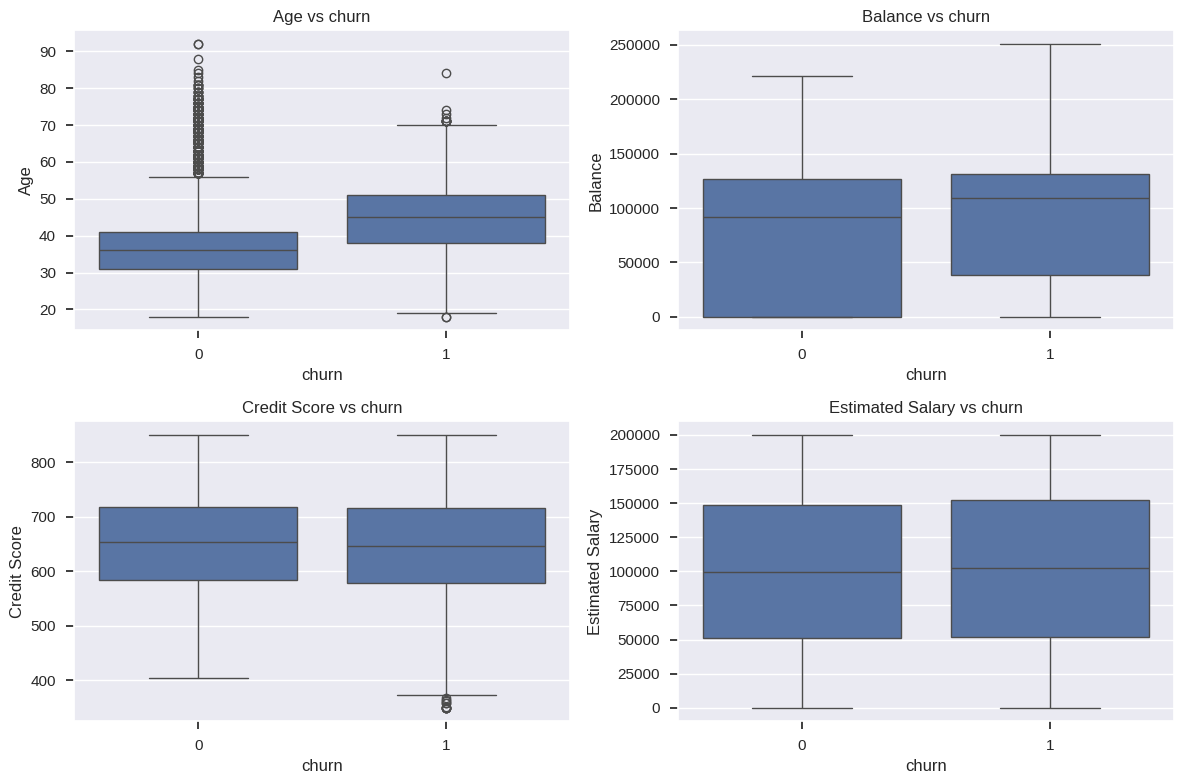

In [9]:
# Target distribution plot
plt.figure(figsize=(5, 3))
ax = sns.countplot(data=df, x=TARGET_COL)
ax.set_title("Target distribution")
ax.set_xlabel(TARGET_COL)
ax.set_ylabel("count")
plt.tight_layout()
plt.show()

# Churn vs key numerical features
key_numerical_features = ["age", "balance", "credit_score", "estimated_salary"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, key_numerical_features):
    sns.boxplot(x=TARGET_COL, y=col, data=df, ax=ax)
    ax.set_title(f"{col.replace('_', ' ').title()} vs {TARGET_COL}")
    ax.set_xlabel(TARGET_COL)
    ax.set_ylabel(col.replace('_', ' ').title())

plt.tight_layout()
plt.show()


## Key Insights from Numerical Features

- **Age** shows a strong association with churn: churned customers tend to be older.
- **Balance** appears to be higher for churned customers, although the distribution is highly skewed and includes many zero-balance accounts.
- **Credit score** shows limited separation between churned and non-churned customers.
- **Estimated salary** does not demonstrate a strong relationship with churn.

These observations suggest that demographic and behavioral features may be more informative than purely financial indicators.


## Categorical Features Analysis

We now analyze categorical features to understand how churn rates
vary across different customer groups.

Categorical features in this dataset:
- Country
- Gender


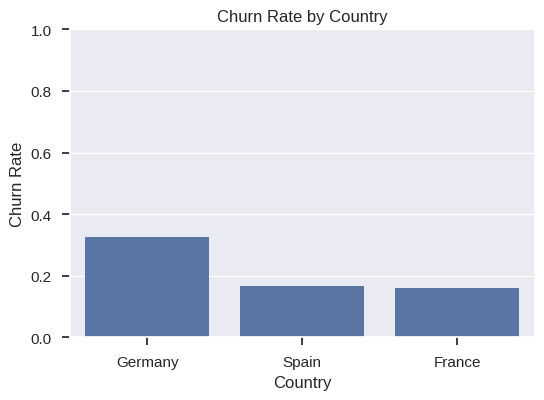

,churn
country,
Germany,0.324
Spain,0.167
France,0.162


In [10]:
# Churn rate by country
churn_by_country = (
    df
    .groupby("country")[TARGET_COL]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(6, 4))
sns.barplot(
    x=churn_by_country.index,
    y=churn_by_country.values
)

plt.title("Churn Rate by Country")
plt.ylabel("Churn Rate")
plt.xlabel("Country")
plt.ylim(0, 1)
plt.show()

churn_by_country


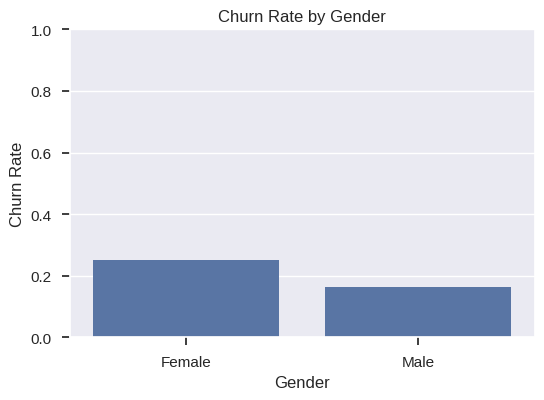

,churn
gender,
Female,0.251
Male,0.165


In [11]:
# Churn rate by gender
churn_by_gender = (
    df
    .groupby("gender")[TARGET_COL]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(6, 4))
sns.barplot(
    x=churn_by_gender.index,
    y=churn_by_gender.values
)

plt.title("Churn Rate by Gender")
plt.ylabel("Churn Rate")
plt.xlabel("Gender")
plt.ylim(0, 1)
plt.show()

churn_by_gender


## Key Insights from Categorical Features

- Churn rates differ noticeably across countries, suggesting regional
  differences in customer behavior.
- Gender shows a smaller but still observable difference in churn rates.
- Country appears to be a more informative categorical feature than gender.

These features are expected to be useful for churn prediction models,
especially tree-based algorithms.
